In [1]:
#RNN을 사용한 주가예측 모델 생성
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
!pip install padas_datareader

ERROR: Could not find a version that satisfies the requirement padas_datareader (from versions: none)
ERROR: No matching distribution found for padas_datareader


<AxesSubplot:xlabel='Date'>

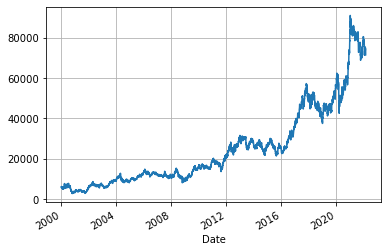

In [3]:
start = (2000, 1, 1)
start = datetime.datetime(*start)
end = datetime.date.today()

df = pdr.DataReader('005930.KS', 'yahoo', start, end)
df.head(5)
df.tail(5)
df.Close.plot(grid=True)

In [4]:
#데이터셋 준비하기
x = df.drop(columns = 'Volume')
y = df.iloc[:, 5:6]

print(x)
print(y)

               High      Low     Open    Close     Adj Close
Date                                                        
2000-01-04   6110.0   5660.0   6000.0   6110.0   4675.781738
2000-01-05   6060.0   5520.0   5800.0   5580.0   4270.190430
2000-01-06   5780.0   5580.0   5750.0   5620.0   4300.802734
2000-01-07   5670.0   5360.0   5560.0   5540.0   4239.582520
2000-01-10   5770.0   5580.0   5600.0   5770.0   4415.592285
...             ...      ...      ...      ...           ...
2022-02-18  74800.0  73700.0  74600.0  74300.0  74300.000000
2022-02-21  74300.0  74300.0  74300.0  74300.0  74300.000000
2022-02-22  74300.0  74300.0  74300.0  74300.0  74300.000000
2022-02-23  74300.0  74300.0  74300.0  74300.0  74300.000000
2022-02-24  72300.0  71300.0  72300.0  71500.0  71500.000000

[5563 rows x 5 columns]
               Adj Close
Date                    
2000-01-04   4675.781738
2000-01-05   4270.190430
2000-01-06   4300.802734
2000-01-07   4239.582520
2000-01-10   4415.592285
...    

In [5]:
#학습성능 향상을 위한 데이터 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler #scikit-learn

mm = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_mm = mm.fit_transform(y)

#train data
x_train = x_ss[:4500, :]
x_test = y_mm[4500:, :]

#test data
y_train = y_mm[:4500, :]
y_test = y_mm[4500:,:]

print("Training Shape", x_train.shape, y_train.shape)
print("Testing Shape", x_test.shape, y_test.shape)

Training Shape (4500, 5) (4500, 1)
Testing Shape (1063, 1) (1063, 1)


In [6]:
#학습을 위한 torch행렬로 변환
x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))

y_train_tensors = Variable(torch.Tensor(y_train)) 
y_test_tensors = Variable(torch.Tensor(y_test))

x_train_tensors_final = torch.reshape(x_train_tensors, 
                                      (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
x_test_tensors_final = torch.reshape(x_test_tensors,
                                    (x_test_tensors.shape[0], 1, x_test_tensors.shape[1]))

print("Training Shape", x_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", x_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([4500, 1, 5]) torch.Size([4500, 1])
Testing Shape torch.Size([1063, 1, 1]) torch.Size([1063, 1])


In [7]:
#gpu 세팅
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

NVIDIA GeForce RTX 3080
True


In [8]:
#RNN계열의 모델 LSTM선언
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size= input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size = input_size,
                           hidden_size = hidden_size,
                           num_layers = num_layers,
                           batch_first = True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        
        output, (hn,cn) = self.lstm(x, (h_0, c_0))
        
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        
        return out

In [9]:
#네트워크에 사용되는 하이퍼 파라미터 선언
num_epochs = 30000
learning_rate = 0.001

input_size = 5 
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers, x_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [10]:
#학습 진행하기
for epoch in range(num_epochs):
    outputs = lstm.forward(x_train_tensors_final.to(device))
    optimizer.zero_grad()
    
    loss = loss_function(outputs, y_train_tensors.to(device))
    
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" %(epoch, loss.item()))

Epoch: 0, loss: 0.06943
Epoch: 100, loss: 0.00116
Epoch: 200, loss: 0.00035
Epoch: 300, loss: 0.00011
Epoch: 400, loss: 0.00004
Epoch: 500, loss: 0.00003
Epoch: 600, loss: 0.00002
Epoch: 700, loss: 0.00002
Epoch: 800, loss: 0.00001
Epoch: 900, loss: 0.00001
Epoch: 1000, loss: 0.00001
Epoch: 1100, loss: 0.00001
Epoch: 1200, loss: 0.00001
Epoch: 1300, loss: 0.00001
Epoch: 1400, loss: 0.00001
Epoch: 1500, loss: 0.00001
Epoch: 1600, loss: 0.00001
Epoch: 1700, loss: 0.00001
Epoch: 1800, loss: 0.00001
Epoch: 1900, loss: 0.00001
Epoch: 2000, loss: 0.00001
Epoch: 2100, loss: 0.00001
Epoch: 2200, loss: 0.00001
Epoch: 2300, loss: 0.00001
Epoch: 2400, loss: 0.00001
Epoch: 2500, loss: 0.00001
Epoch: 2600, loss: 0.00001
Epoch: 2700, loss: 0.00001
Epoch: 2800, loss: 0.00001
Epoch: 2900, loss: 0.00001
Epoch: 3000, loss: 0.00001
Epoch: 3100, loss: 0.00001
Epoch: 3200, loss: 0.00001
Epoch: 3300, loss: 0.00001
Epoch: 3400, loss: 0.00001
Epoch: 3500, loss: 0.00001
Epoch: 3600, loss: 0.00001
Epoch: 3700, 

Epoch: 29800, loss: 0.00000
Epoch: 29900, loss: 0.00000


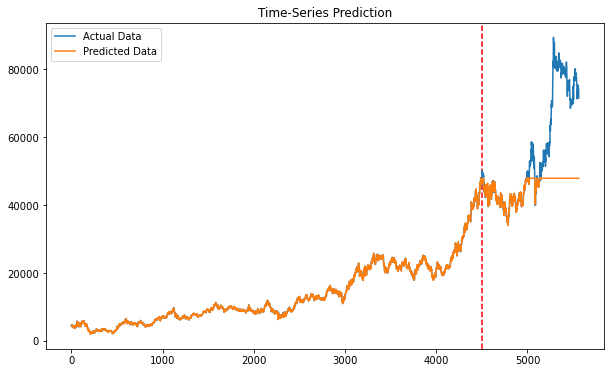

In [11]:
#학습된 모델을 바탕으로 예측
df_x_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(df.iloc[:,5:6])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))

df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = lstm(df_x_ss.to(device))
data_predict = train_predict.data.detach().cpu().numpy()
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict)
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6))
plt.axvline(x=4500, c='r', linestyle='--')

plt.plot(dataY_plot, label='Actual Data')
plt.plot(data_predict, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()